In [153]:
# Bibliotecas - API
import requests

# Bibliotecas - Gráficos
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# Bibliotecas - Dash
import dash
from dash import dcc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# etl 1 (extração de dados)


In [154]:

# define url incrementada para requisição de api (ate 1.000.000 registros)
url = "https://dadosabertos.aneel.gov.br/api/action/datastore_search?resource_id=b1bd71e7-d0ad-4214-9053-cbd58e9564a7&limit=1000000"

# tempo máximo de espera para a resposta da requisição
timeout_seconds = 100   

# Obter os dados da API
def get_data(url, timeout_seconds):
    try:
        # Requisição GET com o tempo limite definido
        response = requests.get(url, timeout=timeout_seconds)

        #  Verifica erros HTTP
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print("Erro ao obter os dados:", e)
        return None

    # Código de status da resposta HTTP=200, indicando que a requisição foi bem sucedida
    if response.status_code == 200:
        # Em caso de sucesso, obtenha os dados em formato JSON e imprima "Requisição bem sucedida"
        data = response.json()
        print("Requisição bem sucedida")

        # Verificar resposta da API
        if data["success"]:
            # Gera lista de registros e a lista de colunas
            records = data["result"]["records"]
            columns = data["result"]["fields"]

            # Adiciona as colunas "Bandeira" e "Nome_agente" na lista de colunas
            columns.append({"id": "Bandeira", "type": "text"})
            columns.append({"id": "Nome_agente", "type": "text"})

            # Cria o DataFrame
            df = pd.DataFrame.from_records(records, columns=[c["id"] for c in columns])

            # Retorne o DataFrame criado
            return df
        else:
            # Em caso de erro, imprir uma mensagem de aviso e retorne None
            print("A API não retornou dados.")
            return None
    else:
        # Se o código de status da resposta HTTP for diferente de 200, trate o erro de acordo com o código
        if response.status_code == 400:
            print("Requisição mal formada.")
        elif response.status_code == 401:
            print("Não autorizado.")
        elif response.status_code == 403:
            print("Acesso proibido.")
        elif response.status_code == 404:
            print("Recurso não encontrado.") 
        elif response.status_code == 500:
            print("Erro interno do servidor.")
        else:
            print("Erro desconhecido ao obter os dados.")

        return None

# Chame a função get_data para obter um DataFrame com os dados da API
df = get_data(url, timeout_seconds)

Requisição bem sucedida


## etl 1.2 (analisando a estrutura)
 
 Análises realizadas : verificações obtidas
 - Formato de dados: inicialmente, algumas colunas do DataFrame possuíam valores do tipo 'object', que foram atualizados para as classes corretas (e.g. 'datetime', 'float', 'int').
 - Análise de valores vazios: não foi identificado um padrão de valores vazios no DataFrame, porém isso não deve ser um problema, uma vez que não pretendemos utilizá-los.

 - Análise de valores nulos: também não foi identificado um padrão de valores nulos no DataFrame, o que não deve ser um problema para nossas análises.
 - Análise de valores duplicados: felizmente, não encontramos valores duplicados no DataFrame, o que é sempre um bom sinal.

Colunas duplicadas:  []
Colunas duplicadas:  0
                             +       %
Nome_agente              32000  100.00
Bandeira                 32000  100.00
NumCoordNSub             31964   99.89
NumCoordESub             31964   99.89
NomSubEstacao            31964   99.89
NumCoordEEmpreendimento  27824   86.95
NumCoordNEmpreendimento  27824   86.95
codRegiao                   57    0.18
codUFibge                   57    0.18
CodEmpreendimento            3    0.01
Número de colunas duplicadas: 0
Número de linhas duplicadas: 0


c:\Users\ghumb\anaconda3\envs\aneel_energisa\lib\site-packages\missingno\missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



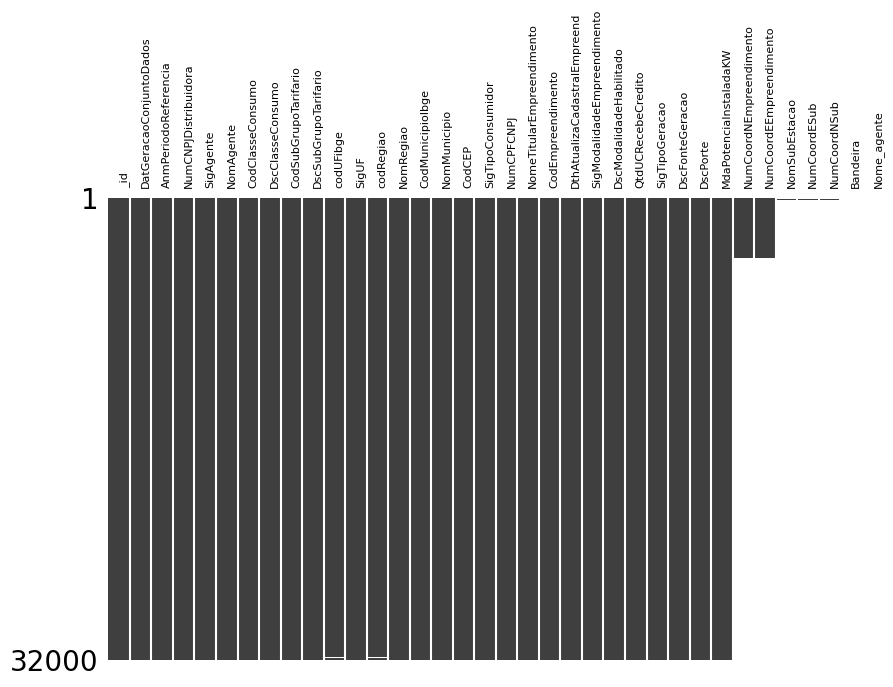

In [158]:

# Atualizando formato de colunas
def atualiza_formato_colunas(df):
    df = df.astype({
        "NumCNPJDistribuidora": np.int64,
        "CodClasseConsumo": np.int64,
        "CodSubGrupoTarifario": np.int64,
        "codUFibge": np.float64,
        "codRegiao": np.float64,
        "CodMunicipioIbge": np.float64,
        "QtdUCRecebeCredito": np.int64,
    })
    return df
df = atualiza_formato_colunas(df)

# análise de vazios
def analyze_dataframe(df):
    # Análise de colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    df_duplicated_col = duplicated_col.sum()
    print('Colunas duplicadas: ', df_duplicated.columns.tolist())

    # Análise de linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    df_duplicated_line = duplicated_rows.sum()
    print('Colunas duplicadas: ', df_duplicated_line.tolist())

    # Análise de valores nulos
    na_tot = df.isna().sum().sort_values(ascending=False)
    na_perc = (df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)
    na = pd.concat([na_tot, na_perc], axis=1, keys=['+', '%'])
    print(na.head(10))
analyze_dataframe(df)

def check_duplicates(df):
    # Verifica colunas duplicadas
    duplicated_cols = df.columns[df.columns.duplicated(keep=False)]
    num_duplicated_cols = len(duplicated_cols)
    
    # Verifica linhas duplicadas
    duplicated_rows = df.duplicated(keep=False)
    num_duplicated_rows = duplicated_rows.sum()
    
    # Retorna o resultado
    return num_duplicated_cols, num_duplicated_rows
print('Número de colunas duplicadas:', num_duplicated_cols)
print('Número de linhas duplicadas:', num_duplicated_rows)


def visualizar_nulos(df):
    sorted_df = df.sort_values(by='NumCoordEEmpreendimento')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Cria a matriz de visualização de nulos com o eixo x em rotação vertical e tamanho de fonte menor
    matriz_nulos = msno.matrix(sorted_df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
    plt.show()
visualizar_nulos(df)



In [163]:




























df.columns

Index(['_id', 'DatGeracaoConjuntoDados', 'AnmPeriodoReferencia',
       'NumCNPJDistribuidora', 'SigAgente', 'NomAgente', 'CodClasseConsumo',
       'DscClasseConsumo', 'CodSubGrupoTarifario', 'DscSubGrupoTarifario',
       'codUFibge', 'SigUF', 'codRegiao', 'NomRegiao', 'CodMunicipioIbge',
       'NomMunicipio', 'CodCEP', 'SigTipoConsumidor', 'NumCPFCNPJ',
       'NomeTitularEmpreendimento', 'CodEmpreendimento',
       'DthAtualizaCadastralEmpreend', 'SigModalidadeEmpreendimento',
       'DscModalidadeHabilitado', 'QtdUCRecebeCredito', 'SigTipoGeracao',
       'DscFonteGeracao', 'DscPorte', 'MdaPotenciaInstaladaKW',
       'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento', 'NomSubEstacao',
       'NumCoordESub', 'NumCoordNSub', 'Bandeira', 'Nome_agente'],
      dtype='object')

# EDA

Análises de interesse:

    - Evoluções do número de usuários por tempo, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - DscClasseConsumo (resid/comercial/industrial) e SigUF(uf)
        - 

    - Análises da potencia instalada por tempo, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 

    - Análises o agente instalada por grupo tarifario, segmentado por: 
        - SigTipoConsumigor (pf/pj) e SigUF(uf)
        - 


Colunas adequadas para utilização: 

 - SigUF - nome do estado do empreendimento
 - NomMunicipio - nome do município do empreendimento

 - SigTipoConsumidor (PF ou PJ)
 - DthAtualizaCadastralEmpreend

 - DscClasseConsumo - descrição da classe de consumo do empreendimento
 - CodSubGrupoTarifario - código do subgrupo tarifário do empreendimento

 - DscFonteGeracao - descrição da fonte de geração do empreendimento

 - NomAgente - nome do agente 
 - DscPorte - descrição do porte do agente
 - MdaPotenciaInstaladaKW - potência instalada do agente em kW

In [428]:
df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')

# exclui nulos
df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

# filtra SigUFs 
df_clean = df_clean[df_clean['SigUF'].isin(['AC', 'AL', 'AM', 'AP'])]

# agrupa os dados
counts = df_clean.groupby(['Ano', 'SigUF','SigTipoConsumidor', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
# ERRADO - tx_anual_tipo = counts.groupby(['NumCPFCNPJ', 'SigTipoConsumidor'])['Ano'].apply(lambda x: x.pct_change().mean())
# ERRADO - tx_anual_classe = counts.groupby(['NumCPFCNPJ', 'DscClasseConsumo'])['Ano'].apply(lambda x: x.pct_change().mean())


# seria bom adicionar uma linha com a taxa de crescimento anual por Tipo de Consumidor
def grafico_novos_usuarios_tipo(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_tipo = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='SigTipoConsumidor')
    fig_novos_tipo.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_novos_tipo.show()
grafico_novos_usuarios_tipo(counts)
#grafico_novos_usuarios_tipo(counts)


# Tornar a o eixo y variável pelo max de cada UF
def grafico_novos_usuarios_tipo_UF(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_tipo_uf = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='SigTipoConsumidor',barmode="group", facet_row="SigUF")
    fig_novos_tipo_uf.update_layout(
        width=800,
        height=600,
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )

    fig_novos_tipo_uf.show()
grafico_novos_usuarios_tipo_UF(counts)


In [423]:
def grafico_novos_usuarios_classe(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_classe = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='DscClasseConsumo')
    fig_novos_classe.update_layout(
        width=1200,
        height=600,
        xaxis_title='Ano',
        xaxis_title_font_size=16,
        yaxis_title='Novos usuários',
        yaxis_title_font_size=16,
        title='Novos usuários por tipo de consumo',
        title_font_size=20,
        title_x=.5
    )
    fig_novos_classe.show()
grafico_novos_usuarios_classe(counts)


def grafico_novos_usuarios_classe_UF(counts):
    counts_filtered = counts.query('Ano >= 2018')
    fig_novos_classe_uf = px.bar(counts_filtered, x="Ano", y="NumCPFCNPJ", color='DscClasseConsumo',barmode="group", facet_row="SigUF")
    fig_novos_classe_uf.update_layout(
        width=800,
        height=600,
        title={
        'text': "Novos usuários",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
        )
    fig_novos_classe_uf.show()
grafico_novos_usuarios_classe_UF(counts)


In [421]:

counts2 = pd.DataFrame(df_clean.groupby(['Ano', 'SigUF','SigTipoConsumidor'])['NumCPFCNPJ'].nunique()).reset_index()
counts2['TaxaCrescimento'] = counts.groupby(['SigTipoConsumidor', 'Ano'])['NumCPFCNPJ'].pct_change() * 100
counts2['TaxaCrescimento'] = counts['TaxaCrescimento'].replace([np.inf, -np.inf], np.nan)

counts2

,Ano,SigUF,SigTipoConsumidor,NumCPFCNPJ,TaxaCrescimento
0,2012,BA,PJ,1,NaN
1,2013,BA,PF,1,NaN
2,2014,BA,PF,9,NaN
3,2014,BA,PJ,6,250.000000
4,2015,AC,PF,1,NaN
...,...,...,...,...,...
83,2023,AP,PF,579,-93.478261
84,2023,AP,PJ,23,NaN
85,2023,BA,PJ,1,-88.888889
86,2023,PA,PF,2,0.000000


In [171]:
# O gráfico 1 mostra a evolução temporal do Total Mensal de Empreendimentos por Estado e por Classe de Consumo;

    # OBS1: estados com menos de 10 empreendimentos foram excluídos do gráfico;
    # OBS2: os dados de 2023 representam um corte até hoje


df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')

# exclui nulos
df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

# filtra SigUFs 
df_clean = df_clean[df_clean['SigUF'].isin(['BA', 'AL', 'AC', 'AM', 'AP'])]

# agrupa os dados
counts = df_clean.groupby(['Ano_Mes', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()

# Cria uma lista com as opções de SigUF para dropdown
sigufs = df_clean['SigUF'].unique()

# cria o gráfico de áreas empilhadas

fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color="DscClasseConsumo", title="Novos usuários da rede distribuida")

# estilo do grafico
fig_3.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano_Mes',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='NumCPFCNPJ',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)


fig_3.update_yaxes(range=[0, 6000])

In [1]:
#___________________________________________________Gráfico 2__________________________________________________#

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year
df['Ano_Mes'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend']).dt.strftime('%Y-%m')

# cria uma cópia do DataFrame sem valores nulos de NumCPFCNPJ
df_clean = df.dropna(subset=['NumCPFCNPJ']).copy()

# filtra apenas as SigUFs desejadas
df_clean = df_clean[df_clean['SigUF'].isin(['BA', 'AL', 'AC', 'AM', 'AP'])]

# agrupa os dados por ano, mês, SigUF e DscClasseConsumo
counts = df_clean.groupby(['Ano_Mes', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()

# Cria uma lista com as opções de SigUF
sigufs = df_clean['SigUF'].unique()

# cria o gráfico de áreas empilhadas animado

fig_3 = px.bar(counts, x="Ano_Mes", y="NumCPFCNPJ", color="DscClasseConsumo", title="Novos usuários da Energia distribuida")

fig_3.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano_Mes',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='NumCPFCNPJ',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)

# Define a faixa de valores do eixo y de acordo com os dados do gráfico
fig_3.update_yaxes(range=[0, 7000])

NameError: name 'pd' is not defined

In [504]:

##___________MATRIZES_____________##

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz['Total'] = matriz.sum(axis=1)
matriz = matriz.fillna(0)

matriz_tx = matriz.iloc[:, :-1].pct_change(axis=1) * 100
matriz_tx= matriz.applymap(lambda x: '{:.0f}%'.format(x) if not np.isinf(x) else '∞')

matriz



Ano,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total
SigUF,,,,,,,,,,,,,
AC,0.0,0.0,0.0,3.0,1.0,16.0,31.0,132.0,504.0,1409.0,1792.0,375.0,4263.0
AL,0.0,0.0,0.0,4.0,14.0,46.0,175.0,617.0,1613.0,3497.0,8152.0,2918.0,17036.0
AM,0.0,0.0,0.0,2.0,5.0,20.0,81.0,428.0,880.0,1582.0,2855.0,863.0,6716.0
AP,0.0,0.0,0.0,0.0,0.0,2.0,36.0,108.0,145.0,477.0,908.0,587.0,2263.0
BA,1.0,1.0,15.0,35.0,106.0,269.0,263.0,4.0,4.0,4.0,7.0,2.0,711.0


In [353]:

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz['Total'] = matriz.sum(axis=1)
matriz = matriz.fillna(0)

matriz_tx = matriz.iloc[:, :-1].pct_change(axis=1) * 100
matriz_tx= matriz.applymap(lambda x: '{:.0f}%'.format(x) if not np.isinf(x) else '∞')


counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()
matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')

matriz.loc['BR'] = matriz.sum()


matriz = matriz.fillna(0)

z_text = matriz.round(2).values.tolist()

fig = ff.create_annotated_heatmap(z=matriz.values,
                                  x=list(matriz.columns),
                                  y=list(matriz.index),
                                  annotation_text=z_text,
                                  font_colors=['gray', 'white'],
                                  colorscale='YlGnBu')

fig.update_layout(yaxis={'type': 'category'})


fig.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='SigUF',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)

fig.show()

In [488]:

matriz_tx

Ano,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total,med,2023
SigUF,,,,,,,,,,,,,,,
AC,nan%,nan%,nan%,inf%,-67%,1500%,94%,326%,282%,180%,27%,-79%,0,0,0
AL,nan%,nan%,nan%,inf%,250%,229%,280%,253%,161%,117%,133%,-64%,0,0,0
AM,nan%,nan%,nan%,inf%,150%,300%,305%,428%,106%,80%,80%,-70%,0,0,0
AP,nan%,nan%,nan%,nan%,nan%,inf%,1700%,200%,34%,229%,90%,-35%,0,0,0
BA,nan%,0%,1400%,133%,203%,154%,-2%,-98%,0%,0%,75%,-71%,0,0,0


In [512]:


df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

counts = df_clean.groupby(['Ano', 'SigUF', 'DscClasseConsumo']).agg({'NumCPFCNPJ': 'nunique'}).reset_index()
tabela = counts.groupby(['Ano', 'SigUF'])['NumCPFCNPJ'].sum().reset_index()

matriz = tabela.pivot(index='SigUF', columns='Ano', values='NumCPFCNPJ')
matriz = matriz.fillna(0)
matriz.loc['BR'] = matriz.sum()

matriz_tx = matriz.pct_change(axis=1) * 100
matriz_tx = matriz_tx.applymap(lambda x: '{:.0f}%'.format(x) if not np.isnan(x) and x != 0 else ' ')
matriz_tx['med'] = ""
matriz_tx['Total'] = ""
matriz_tx['2023'] = ""





import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np

# Criando uma lista de strings com valores da matriz e matriz_tx
text = [[f"{matriz.iloc[i,j]:}<br>{matriz_tx.iloc[i,j]}" for j in range(len(matriz.columns))] for i in range(len(matriz.index))]
# Criação do heatmap principal
fig_2 = ff.create_annotated_heatmap(z=matriz.values,
                                  x=list(matriz.columns),
                                  y=list(matriz.index),
                                  annotation_text=text,
                                  font_colors=['gray', 'white'],
                                  colorscale='YlGnBu')
# Configurações de layout
fig_2.update_layout(
    width=1200,
    height=600,
    xaxis_title='Ano',
    xaxis_title_font_size=16,
    xaxis_tickfont_size=14,
    yaxis_title='SigUF',
    yaxis_title_font_size=16,
    yaxis_tickfont_size=14,
    title='Novos usuários da Energia distribuida',
    title_font_size=20,
    title_x=.5,
    margin=dict(t=130)
)    

fig_2.show()



In [ ]:
import pandas as pd
import plotly.express as px

# Manipulações para Gráfico - evolução temporal da Potência Instalada Total (KW) por Estado;
df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

# Agrupar dados por mês, ano e estado e somar as potências instaladas
counts = df.groupby(['SigUF', 'Ano', 'Mes']).agg({'MdaPotenciaInstaladaKW': 'sum'}).reset_index()

# Criar gráfico de barras empilhadas
fig_2 = px.bar(counts, x="Ano", y="MdaPotenciaInstaladaKW", color="SigUF", barmode="relative")

# Atualizar layout do gráfico
fig_2.update_layout(
    title='Evolução da Potência Instalada Total (KW) por Estado',
    xaxis_title='Ano',
    yaxis_title='Potência Instalada Total (KW)',
    legend_title='Estado',
    font=dict(size=14, color="#7f7f7f"),
    hovermode='x unified'
)

dcc.Graph(id='graph2', figure=fig_2)
fig_2.show()

In [50]:
###_________RPREVISAO__2023__________##


mport pandas as pd
import plotly.express as px
from fbprophet import Prophet

# Manipulações para Gráfico - evolução temporal da Potência Instalada Total (KW) por Estado;
df['Mes'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).month
df['Ano'] = pd.DatetimeIndex(df['DthAtualizaCadastralEmpreend']).year

# Agrupar dados por mês, ano e estado e somar as potências instaladas
counts = df.groupby(['SigUF', 'Ano', 'Mes']).agg({'MdaPotenciaInstaladaKW': 'sum'}).reset_index()

# Renomear as colunas para ds e y, que são as convenções do Prophet
counts = counts.rename(columns={'Ano': 'ds', 'MdaPotenciaInstaladaKW': 'y'})

# Filtrar apenas os dados do estado desejado para fazer a previsão
state_counts = counts[counts['SigUF'] == 'UF']

# Ajustar um modelo com a biblioteca Prophet
m = Prophet()
m.fit(state_counts)

# Fazer a previsão para o período desejado (2023)
future = m.make_future_dataframe(periods=12*10, freq='M')  # 10 anos de previsão
forecast = m.predict(future)

# Criar gráfico com os dados históricos e a previsão
fig = px.line(forecast, x='ds', y='yhat', title='Previsão de Potência Instalada em UF')
fig.add_scatter(x=state_counts['ds'], y=state_counts['y'], name='Histórico', mode='markers')
fig.show()

SyntaxError: invalid syntax (4215381843.py, line 4)

In [ ]:
# Regressão Linear: um modelo que tenta ajustar uma reta aos pontos de dados para prever o valor de uma variável dependente (potência instalada total) com base em uma ou mais variáveis independentes (como ano, estado, município, entre outras).

# prever crescimento em Potencia Instalada Total nos próximos 12 meses de estados e municípios  relacionando com dados da API IBGE

In [ ]:
#Regressão Logística: um modelo utilizado para prever uma variável binária (como, por exemplo, se um município ou estado terá um crescimento acima ou abaixo da média) com base em uma ou mais variáveis independentes.

#prever o formato de energia que terá maior crescimento em cada estado nos próximos 12 meses

In [ ]:
# importando bibs

from prophet import Prophet
import pandas as pd

#carregando dados (obs: colunas obrigatoriamente tem que se chamar ds para a data e y para os valores

dataframe = pd.read_excel("/content/aneel.xlsx")
dataframe = dataframe.rename(columns={'DS':'ds', 'Y':'y'})
dataframe

# instancia o objeto prophet
m = Prophet()
m.fit(dataframe)

# define o quanto quer prever (no caso foi usado 12 meses, freq = M para meses, 'D' para dias.
future = m.make_future_dataframe(periods = 12, freq='M')
future.tail()

#plotar o gráfico
fig1 = m.plot(forecast)

# plotando com a bibs plotly
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

# decompondo a série
fig2 = m.plot_components(forecast)

In [ ]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Selecionar as colunas necessárias para a análise
df['MdaPotenciaInstaladaKW'] = df['MdaPotenciaInstaladaKW'].astype('str')
df['MdaPotenciaInstaladaKW'] = df['MdaPotenciaInstaladaKW'].str.replace(',', '.')
df['MdaPotenciaInstaladaKW'] = pd.to_numeric(df['MdaPotenciaInstaladaKW'], errors='coerce')
df['DthAtualizaCadastralEmpreend'] = pd.to_datetime(df['DthAtualizaCadastralEmpreend'])
df['DthAtualizaCadastralEmpreend'] = df['DthAtualizaCadastralEmpreend'].apply(lambda x: x.timestamp())

# Agrupar o dataframe por tipo de geração
groups = df.groupby('DscClasseConsumo')

# Criar um dicionário para armazenar as previsões de cada grupo
predictions = {}

# Iterar sobre os grupos e aplicar o modelo de regressão linear
for name, group in groups:
    X = group['DthAtualizaCadastralEmpreend'].values.reshape(-1, 1)
    y = group['MdaPotenciaInstaladaKW'].values
    
    # Instanciar o modelo de regressão linear
    model = LinearRegression()
    
    # Treinar o modelo com os dados selecionados
    model.fit(X, y)
    
    # Fazer a previsão para os próximos 12 meses
    previsao = model.predict([[group['DthAtualizaCadastralEmpreend'].max() + i] for i in range(1, 13)])
    
    # Criar um dataframe com as previsões
    data_atual = datetime.now()
    previsoes = []
    for i, p in enumerate(previsao):
        data = (data_atual + timedelta(days=30*(i+1))).strftime('%Y-%m-%d')
        previsoes.append({'data': data, 'previsao': p})
        
    df_previsoes = pd.DataFrame(previsoes)
    
    # Armazenar o dataframe no dicionário com o nome do grupo como chave
    predictions[name] = df_previsoes
    
# Imprimir as previsões de cada grupo
for key, value in predictions.items():
    print(f'Previsões para {key}:')
    print(value)



Previsões para Comercial:
          data   previsao
0   2023-04-20  32.121854
1   2023-05-20  32.121854
2   2023-06-19  32.121854
3   2023-07-19  32.121854
4   2023-08-18  32.121854
5   2023-09-17  32.121854
6   2023-10-17  32.121854
7   2023-11-16  32.121854
8   2023-12-16  32.121854
9   2024-01-15  32.121854
10  2024-02-14  32.121854
11  2024-03-15  32.121854
Previsões para Industrial:
          data   previsao
0   2023-04-20  63.679409
1   2023-05-20  63.679409
2   2023-06-19  63.679409
3   2023-07-19  63.679409
4   2023-08-18  63.679409
5   2023-09-17  63.679409
6   2023-10-17  63.679409
7   2023-11-16  63.679409
8   2023-12-16  63.679409
9   2024-01-15  63.679409
10  2024-02-14  63.679409
11  2024-03-15  63.679409
Previsões para Poder Público:
          data   previsao
0   2023-04-20  51.436063
1   2023-05-20  51.436063
2   2023-06-19  51.436063
3   2023-07-19  51.436063
4   2023-08-18  51.436063
5   2023-09-17  51.436063
6   2023-10-17  51.436063
7   2023-11-16  51.436063
8   202

,data,previsao
0,2023-04-20,53.166667
1,2023-05-20,53.166667
2,2023-06-19,53.166667
3,2023-07-19,53.166667
4,2023-08-18,53.166667
5,2023-09-17,53.166667
6,2023-10-17,53.166667
7,2023-11-16,53.166667
8,2023-12-16,53.166667
9,2024-01-15,53.166667


Existem diferentes maneiras de validar se suas previsões estão corretas. Uma maneira é aplicar seu modelo a outro conjunto de dados e verificar seu desempenho1. Você pode usar métricas como R-quadrado, erro quadrático médio ou erro absoluto médio para medir o quão bem seu modelo se ajusta aos novos dados. Você também pode plotar um gráfico de dispersão dos valores previstos versus os valores observados e ver o quão próximos eles estão de uma linha reta.

Outra maneira é verificar as suposições da regressão linear, como linearidade, normalidade, homocedasticidade, independência dos erros e ausência de multicolinearidade2. Você pode usar gráficos diagnósticos como gráfico de resíduos, gráfico Q-Q, gráfico de alavancagem ou valores VIF (fator de inflação da variância) para testar essas suposições e ver se seu modelo precisa de algum ajuste.

Uma terceira maneira é validar externamente seu modelo de previsão usando um método chamado calibração34. Isso envolve comparar as probabilidades previstas com os resultados observados em um novo conjunto de dados e ver o quão bem eles concordam. Você pode usar estatísticas como inclinação e interceptação da calibração ou gráficos como curva ou diagrama de confiabilidade da calibração para avaliar a calibração do seu modelo.

In [18]:
import dash_html_components as html
from dash import Dash, dcc
from dash.dependencies import Input, Output
from dash.exceptions import PreventUpdate
import plotly.graph_objs as go
#import plotly.io as pio
from dash_html_components import Iframe


# Cores: (rgb(68,199,244)); rgb(37,143,185); rgb(245,145,6)

# Carrega os gráficos do Desafio 1.inpn

app = Dash(__name__)

fig_style = {'padding': '0 20px'}

# Defina o layout
app.layout = html.Div(
    style={
        'display': 'flex',
        'flex-direction': 'column',
        'align-items': 'center',
        'height': '100vh',
        'background-color': 'rgb(68, 199, 244)',
    },
    children=[
        html.Img(
            src='https://i2.energisa.info/SiteAssets/topo-marca.png',
            alt='Logo Energisa',
            title='Energisa',
            style={'height': '50px'},
        ),
        html.H1(
            children='Desafi',
            style={
                'font-size': '36px',
                'font-family': 'Arial, sans-serif',
                'font-weight': 'bold',
                'color': '#0074D9',
                'margin-top': '30px',
                'text-align': 'center',
            },
        ),
        html.Div(
            children='''OBS: Estou muito animado para compartilhar estes gráficos com você!''',
            style={'margin-top': '20px'},
        ),

        html.Div(children=[
            html.H2(children='Gráfico atualizado'),
            dcc.Graph(figure=fig_1)
        ]),

        # Define as funções para atualização dos gráficos
        html.Div(children=[
            html.H2(children='Gráfico atualizado'),
        #    dcc.Graph(id='graph2'),
        #    dcc.Graph(id='graph3')
        ], style={'backgroundColor': '#FFF5EE'})
    ],
)

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off
